In [1]:
#encoding=utf-8

In [2]:
import requests
import re
import jieba
import wordcloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud

## ==========爬取全唐诗的简易爬虫==========

#### 获取诗人列表

In [3]:
def get_lib():
    print('初始化诗人列表...')
    lib_url = 'https://www.gushiwen.org/gushi/quantang.aspx'
    lib_response = requests.get(lib_url)
    lib_response.encoding = 'utf-8'
    lib_html = lib_response.text
    poet_list = re.findall(r'<span><a.*?" t', lib_html)
    poet_name = re.findall(r'卷.*?<', lib_html)
    tmp = []
    for x in poet_list:
        t = 'https://www.gushiwen.org' + x[15:29]
        tmp.append(t)
    poet_list = tmp    
    tmp = []
    for x in poet_name:
        t = x[4:len(x)-1]
        tmp.append(t)
    poet_name = tmp
    print('完成！')
    return poet_name, poet_list

#### 获取目标诗人的url

In [4]:
def get_poet_url(name, poet_name, poet_list):
    res = []
    for i in range(len(poet_name)):
        if poet_name[i] == name:
            res.append(poet_list[i])
    return res

#### 爬取目标文本

In [5]:
def run(target, poet_name, poet_list):
    print("查找中......")
    target_url = get_poet_url(target, poet_name, poet_list)
    target_content = []
    target_info = ''
    text_chap = 0
    if target_url == []:
        print("未找到该诗人！")
        return '',[], [], 0, 0
    else:
        for x in target_url:
            text_chap += 1
            target_res = requests.get(x)
            target_res.encoding = 'utf-8'
            target_html = target_res.text
            if target_info == '':
                target_info = re.findall(r'txtareAuthor.*?。?”?https', target_html, re.S)
                if target_info != []:
                    target_info = target_info[0]
                a = 0
                for x in range(len(target_info)):
                    if target_info[x] == '>':
                        a = x
                        break
                target_info = target_info[a+1:len(target_info)-5]
            target_text = re.findall(r'contson.*?width:1', target_html, re.S)[0]
            target_text = target_text.replace('<br /><br />', '\n')
            target_text = target_text.replace('contson">', '')
            target_text = target_text.replace('</div>', '')
            target_text = target_text.replace('<div style=" width:1', '')
            target_text = target_text.replace('</strong></a>', '')
            rubbish_text = re.findall(r'<a href.*?<strong>', target_text)
            for y in rubbish_text:
                target_text = target_text.replace(y, '')
            rubbish_text2 = re.findall(r'<a.*?a>', target_text)
            for y in rubbish_text2:
                target_text = target_text.replace(y, '')
    #         print(target_text)
            target_content.append(target_text)
    print("查找完成！")
    text_title = []
    text_content = []
    for i in target_content:
        for x in i.split():
            if x[0] == '「':
                text_title.append(x)
            elif x[0] == '卷':
                continue
            else:
                text_content.append(x)
    return target_info, text_title, text_content, text_chap, 1

## ==========输出诗人简介==========

In [6]:
def print_info(target, target_info, target_chap, text_title, text_content):
    print("===========================================================================================")
    print('诗人简介：')
    if target_info == '':
        print('不详。')
    else:
        print(target_info)
    print("===========================================================================================")
    print("《全唐诗》收录卷数：", target_chap)
    print("《全唐诗》收录作品数：", len(text_title))
    cnt = 0
    stopwords = "，。！？、（）《》【】<>=:+-—"
    for x in text_content:
        for y in x:
            if y not in stopwords:
                cnt += 1
    print("《全唐诗》收录作品总字数：约", cnt, "字")
    print("平均每作品字数：", round(cnt/len(text_title)), "字")

## ==========词频统计&可视化==========

#### 保存文本为`txt`格式

In [7]:
def savetxt(text_content):
    f = open('./PoetryOfTang/tmp.txt', 'w')
    for x in text_content:
        t = ' '.join(jieba.cut(x))
        t = t.split()
        for y in t:
            f.write(y)
            f.write(' ')
    f.close()

#### 生成词云保存为`png`格式并输出

In [8]:
def gen_wc(target):
    wc = WordCloud(
        font_path=r"./System/Library/PingFang.ttc",
        background_color='white',
    )
    f = open('./PoetryOfTang/tmp.txt')
    text = f.read()
    f.close()
    wc.generate(text)
    wc.to_file('./PoetryOfTang/' + target + '.png')
    print('词频统计词云：')
    plt.imshow(wc)
    plt.axis('off')
    plt.show()
    print("===========================================================================================")

## ==========字频统计==========

#### 统计字频并输出前`num`位

In [9]:
def word_count(target, num):
    word_lst = []
    word_dict = {}
    stopwords = "，。！？、（）《》【】<>=:+-"
    with open('./PoetryOfTang/tmp.txt') as infile:
        for line in infile:
            for char in line:
                word_lst.append(char)
        for char in word_lst:
            if char not in stopwords:
                if char.strip() not in word_dict:
                    word_dict[char] = 1
                else:
                    word_dict[char] += 1
    lstWords = sorted(word_dict.items(), key=lambda x:x[1],  reverse=True) 
    print("===========================================================================================")
    print("最常用字（前20位）：")
    print ('--------------')
    print ('用字 | 次数')
    print ('--------------')
    for e in lstWords[:num]:
        print ('  %s  | %d' % e)
    print("===========================================================================================")

## ==========主函数==========

In [10]:
def main():
    target = input('请输入你要查找的诗人：')
    target_info, text_title, text_content, target_chap, target_find = run(target, poet_name, poet_list)
    if target_find == 1:
        savetxt(text_content)
        print_info(target, target_info, target_chap, text_title, text_content)
        word_count(target, 20)
        gen_wc(target)

In [11]:
poet_name, poet_list = get_lib()
print(poet_name)

初始化诗人列表...
完成！
['李世民', '李治', '李隆基', '李亨', '武则天', '李贤', '鲍君徽', '南唐诸人', '徐氏', '郊庙歌辞', '郊庙歌辞', '郊庙歌辞', '郊庙歌辞', '郊庙歌辞', '郊庙歌辞', '郊庙歌辞', '乐府杂曲', '横吹曲辞', '相和歌辞', '相和歌辞', '相和歌辞', '舞曲歌辞', '琴曲歌辞', '杂曲歌辞', '杂曲歌辞', '杂曲歌辞', '杂曲歌辞', '杂曲歌辞', '杂歌谣辞', '王珪', '魏徵', '褚亮', '刘孝孙', '杨师道', '许敬宗', '虞世南', '王绩', '郑世翼', '陈子良', '上官仪', '卢照邻', '卢照邻', '李百药', '刘祎之', '陈元光', '韦承庆', '张九龄', '张九龄', '张九龄', '杨炯', '宋之问', '宋之问', '宋之问', '崔湜', '王勃', '王勃', '李峤', '李峤', '李峤', '李峤', '李峤', '杜审言', '董思恭', '姚崇', '苏味道', '郭震', '王无竞', '崔融', '阎朝隐', '李適', '刘宪', '高正臣', '苏颋', '苏颋', '蔡孚', '徐彦伯', '骆宾王', '骆宾王', '骆宾王', '武三思', '乔知之', '刘希夷', '陈子昂', '陈子昂', '张说', '张说', '张说', '张说', '张说', '张均', '韦嗣立', '李乂', '卢藏用', '吴少微', '沈佺期', '沈佺期', '沈佺期', '赵冬曦', '张循之', '司马逸客', '宋务光', '武平一', '赵彦昭', '萧至忠', '辛替否', '郑愔', '源乾曜', '李元纮', '李適之', '张谔', '韩休', '贺知章', '裴耀卿', '包融', '李憕', '张子容', '张旭', '孙逖', '崔国辅', '崔珪', '李林甫', '卢象', '卢鸿一', '徐安贞', '王维', '王维', '王维', '王维', '王缙', '崔颢', '祖咏', '李颀', '李颀', '李颀', '綦毋潜', '储光羲', '储光羲', '储光羲', '储光羲', '王昌龄', '王昌龄', '王昌龄', '王昌龄', '常建', '杜頠', 

请输入你要查找的诗人：韦庄
查找中......
查找完成！
诗人简介：
韦庄（约836年─910年），字端己，杜陵（今中国陕西省西安市附近）人，诗人韦应物的四代孙，唐朝花间派词人，词风清丽，有《浣花词》流传。曾任前蜀宰相，谥文靖。
《全唐诗》收录卷数： 6
《全唐诗》收录作品数： 312
《全唐诗》收录作品总字数：约 16702 字
平均每作品字数： 54 字
最常用字（前20位）：
--------------
用字 | 次数
--------------
  不  | 163
  人  | 134
  一  | 112
  花  | 104
  云  | 103
  上  | 103
  日  | 99
  风  | 94
  山  | 93
  年  | 91
  何  | 90
  无  | 88
  月  | 81
  来  | 81
  归  | 80
  去  | 78
  如  | 78
  雨  | 76
  红  | 76
  春  | 76
词频统计词云：


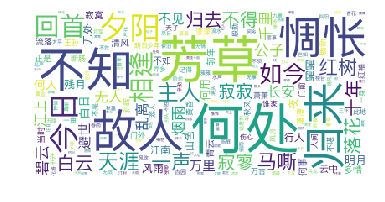

In [14]:
main()